In [1]:
# Base packages import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
# Sample dataset download
from pykrx import stock
import yfinance as yf
import FinanceDataReader as fdr

stocks = fdr.StockListing('KRX')
metadata_df = stocks[40:50] # Sample
ticker_list = metadata_df['Code'].astype(str).tolist()
market_cap_dict = {key: value for key, value in zip(metadata_df['Name'], metadata_df['Marcap'])}

In [41]:
def get_data(tickers, start_date, end_date, per='m'):
    from tqdm import tqdm
    from pykrx import stock

    df = pd.DataFrame()
    for ticker in tqdm(ticker_list):
        tmp_series = stock.get_market_ohlcv(start_date, end_date, ticker, per)
        tmp_series = tmp_series['종가']
        tmp_series.name = stock.get_market_ticker_name(ticker)
        df[tmp_series.name] = tmp_series
    return df

In [107]:
start_date = '20080101'
end_date = '20230901'
sample = get_data(ticker_list, start_date, end_date)

100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


In [108]:
market_prices = fdr.DataReader('KS11', start_date, end_date).resample('M').last()['Adj Close']
market_prices.name = '코스피'

In [109]:
# Black-litterman portfolio
from pypfopt import black_litterman, risk_models

sample_df = sample.pct_change()[1:]
cov_matrix = sample_df.cov()
mcaps = market_cap_dict.copy()

delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)

In [115]:
# Sample view insert

Q = np.array([0.20, 0.05, 0.10, 0.15]).reshape(-1, 1)
P = np.array(
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, -1, 0, 0],
        [0, 0, 0, 0, 0.5, -1, 1, -0.5, 0, 0],
    ]
)

In [116]:
from pypfopt.black_litterman import BlackLittermanModel

viewdict = {"우리금융지주": 0.20, 
            "S-Oil": -0.30, 
            "기업은행": 0, 
            "KT": -0.2, 
            "HMM": 0.15}
bl = BlackLittermanModel(cov_matrix, pi=prior, Q=Q, P=P)

In [117]:
import numpy as np
import pandas as pd
from pypfopt import BlackLittermanModel
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

rets = bl.bl_returns()
ef = EfficientFrontier(rets, cov_matrix)

In [118]:
bl.bl_weights(delta)
weights = bl.clean_weights()

Expected annual return: 10.4%
Annual volatility: 6.7%
Sharpe Ratio: 1.25


<AxesSubplot:xlabel='Weight'>

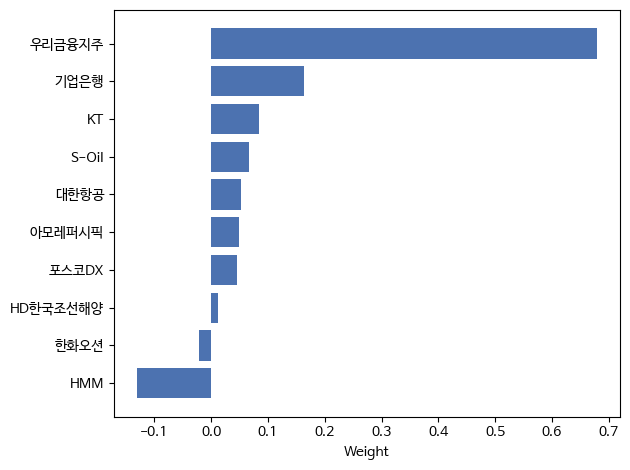

In [119]:
bl.portfolio_performance(weights)
plotting.plot_weights(weights)

In [126]:
sum(weights.values())

1.00001